In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import load_model
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/content/VIC Historical Data (5).csv")
df

,Date,Price,Open,High,Low,Vol.,Change %
0,11/30/2015,31.476,31.109,31.476,31.035,1.28M,0.47%
1,12/1/2015,31.476,31.550,31.623,31.403,355.81K,0.00%
2,12/2/2015,31.329,31.623,31.844,31.329,984.00K,-0.47%
3,12/3/2015,31.476,31.329,31.550,31.256,567.97K,0.47%
4,12/4/2015,31.109,31.329,31.550,31.035,767.62K,-1.17%
...,...,...,...,...,...,...,...
1747,11/24/2022,61.000,60.000,62.100,60.000,1.14M,2.18%
1748,11/25/2022,65.000,63.000,65.000,62.600,2.29M,6.56%
1749,11/28/2022,65.000,66.500,67.100,65.000,3.25M,0.00%
1750,11/29/2022,69.400,65.000,69.400,64.200,3.56M,6.77%


Text(0, 0.5, 'Prices (VND)')

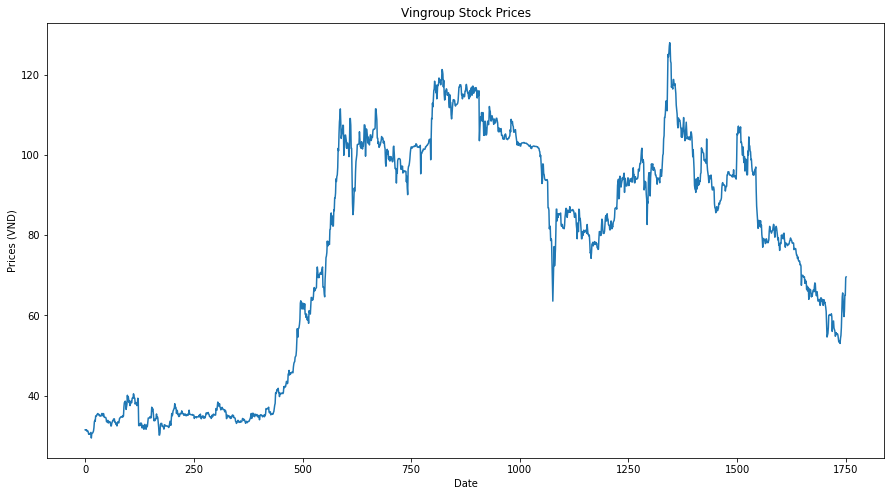

In [3]:
plt.figure(figsize=(15, 8))
plt.title('Vingroup Stock Prices')
plt.plot(df['Price'])
plt.xlabel('Date')
plt.ylabel('Prices (VND)')

In [4]:
p = df['Price']
v = p.values
train_data_len = math.ceil(len(v)* 0.9)

In [5]:
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(v.reshape(-1,1))

train_data = scaled_data[0: train_data_len, :]

In [6]:
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [7]:
test_data = scaled_data[train_data_len-60: , : ]
X_test = []
y_test = v[train_data_len:]

for i in range(60, len(test_data)):
  X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [8]:
model = Sequential()
model.add(layers.LSTM(units = 64,input_shape=(X_train.shape[1], 1),return_sequences=True))
model.add(Dropout(0.5))
model.add(layers.LSTM(units = 64, return_sequences=True))
model.add(Dropout(0.5))
model.add(layers.LSTM(units = 64, return_sequences=False))
model.add(Dropout(0.5))
model.add(layers.Dense(25))
model.add(layers.Dense(1))

In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size= 32, epochs=10)

Epoch 1/10
48/48 [==============================] - 11s 104ms/step - loss: 0.0283
Epoch 2/10
48/48 [==============================] - 5s 102ms/step - loss: 0.0110
Epoch 3/10
48/48 [==============================] - 5s 103ms/step - loss: 0.0088
Epoch 4/10
48/48 [==============================] - 5s 102ms/step - loss: 0.0076
Epoch 5/10
48/48 [==============================] - 6s 124ms/step - loss: 0.0064
Epoch 6/10
48/48 [==============================] - 5s 101ms/step - loss: 0.0058
Epoch 7/10
48/48 [==============================] - 5s 102ms/step - loss: 0.0053
Epoch 8/10
48/48 [==============================] - 5s 103ms/step - loss: 0.0046
Epoch 9/10
48/48 [==============================] - 5s 105ms/step - loss: 0.0046
Epoch 10/10
48/48 [==============================] - 5s 104ms/step - loss: 0.0040


In [10]:
pred = model.predict(X_test)
pred = sc.inverse_transform(pred)

6/6 [==============================] - 2s 27ms/step


In [11]:
train_data.shape

(1577, 1)

In [12]:
# Create an input array using the last 10 days of the scaled test data
x_input = train_data[1567:].reshape(1, -1)

print(x_input.shape)

(1, 10)


In [13]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

print(temp_input)

[0.5039712729375248, 0.5029568992625504, 0.49585628353772965, 0.49585628353772965, 0.4938275361877808, 0.4968706572127041, 0.5009281519126016, 0.5232443727620382, 0.5354168568617308, 0.5273018674619356]


In [14]:
# Initialize variables
lst_output = []
n_steps = 10
i = 0

while(i < 30):
    if(len(temp_input) > 10):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps,1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i += 1

In [15]:
y_pred_future = sc.inverse_transform(lst_output)

print(y_pred_future)

[[79.99330605]
 [80.15014837]
 [80.32387833]
 [80.53671897]
 [80.73337122]
 [80.92481733]
 [81.08044331]
 [81.19980847]
 [81.18027663]
 [81.10399434]
 [81.10096232]
 [81.19617122]
 [81.27844117]
 [81.3470729 ]
 [81.40093824]
 [81.44286353]
 [81.47476436]
 [81.50008994]
 [81.52173714]
 [81.54826143]
 [81.5818663 ]
 [81.6165641 ]
 [81.64579723]
 [81.67082313]
 [81.69281114]
 [81.71288945]
 [81.73181018]
 [81.75010219]
 [81.76801813]
 [81.7855815 ]]


In [ ]:
import datetime as dt

# Convert the 'date' column in the dataframe to a list of strings
datelist_train = df['Date'].astype(str).tolist()

# Parse the date strings using strptime(), using the correct format string
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Generate a list of future dates, starting from the last date in the training data and going for 15 days
datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

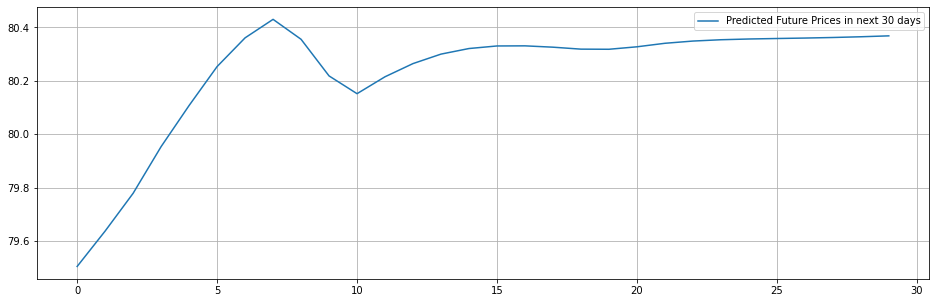

In [46]:
# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(y_pred_future, label='Predicted Future Prices in next 30 days')

# Add a legend and grid
plt.legend()
plt.grid()

In [29]:
pred2 = model.predict(X_train)
pred2 = sc.inverse_transform(pred2)

37/37 [==============================] - 1s 32ms/step


<ipython-input-65-537967364b01>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['Predictions'] = pred


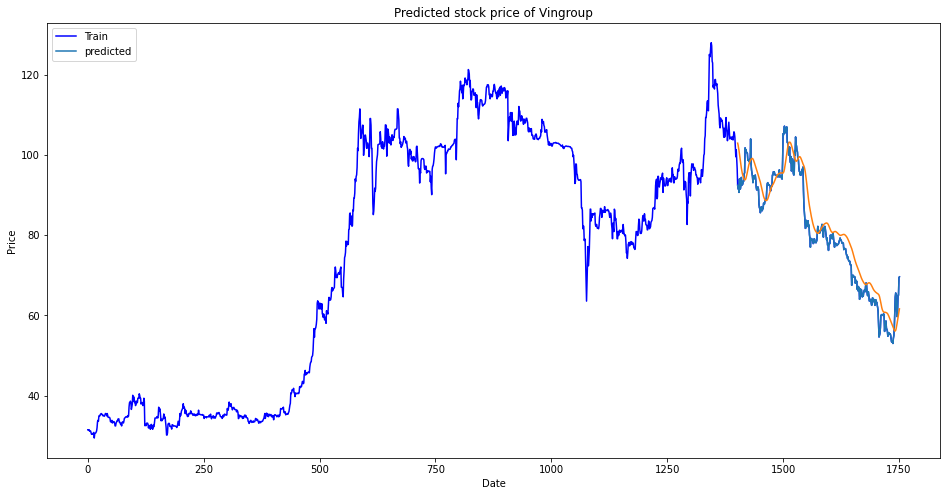

In [65]:
data = df.filter(['Price'])
train = data[:train_data_len]
#real_price = df[train_data_len:]['Price'].values.reshape(-1,1)
#real_price = np.array(real_price)
#real_price = real_price.reshape(real_price.shape[0], 1)
val = data[train_data_len:]
val['Predictions'] = pred
plt.figure(figsize=(16,8))
plt.title('Predicted stock price of Vingroup')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(df['Price'], color='blue', label='Actual Price')
#plt.plot(pred2, color='red')
plt.plot(val[['Price', 'Predictions']])
plt.legend(['Train', 'predicted'], loc='upper left')
plt.show()

In [66]:
real_data=val['Price']

mape = mean_absolute_percentage_error(real_data, pred)
mse = mean_squared_error(real_data, pred)
rmse = np.sqrt(mse)
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse:.0f}")

MAPE: 4.77%
RMSE: 5
